<a href="https://colab.research.google.com/github/SJSY126/gasyori100/blob/master/41_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q  --user numpy matplotlib opencv-python sklearn scikit-image --upgrade

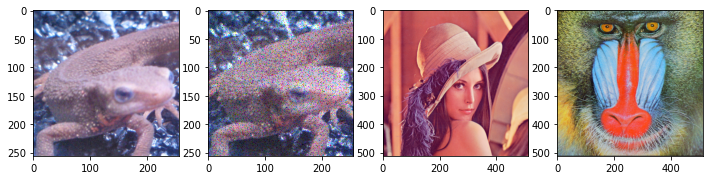

In [4]:
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
import scipy as sp

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256.png')
img_lena = io.imread('http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/lena_std.bmp')
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_noise.png')
img_mandrill = io.imread('http://www.mis.med.akita-u.ac.jp/~kata/image/originalsource/mandrill.jpg')
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_dark.png')

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(img_orig)
plt.subplot(1,4,2)
plt.imshow(img_noise)
plt.subplot(1,4,3)
plt.imshow(img_lena)
plt.subplot(1,4,4)
plt.imshow(img_mandrill)
plt.show()

In [126]:
# func_list

def rgb2gray(img):
    _img = img.copy().astype(np.float32)
    img_gray = 0.2126*_img[...,0] + 0.7153*_img[...,1] + 0.0722*_img[...,2]
    img_gray = np.clip(img_gray,0,255)
    return img_gray.astype(np.uint8)

def binary(img_gray,th):
    _img = img_gray.copy().astype(np.float32)
    img_binary = np.minimum(_img//th, 1)
    img_binary = np.clip(img_binary,0,255)
    return img_binary.astype(np.uint8)

def rgb2binary(img,th):
    _img = img.copy().astype(np.float32)
    img_gray = rgb2gray(_img)
    img_binary = binary(img_gray,th)
    return img_binary

def otsu_thresh(img):
    _img = img.copy().astype(np.float32)

    max_vari = -1
    max_th = -1

    for th in range(1,254):
        m0 = _img[_img <= th].mean()
        m1 = _img[_img >  th].mean()
        w0 = _img[_img <= th].size
        w1 = _img[_img > th].size
        vari = w0 * w1 / ((w0 + w1) ** 2) * ((m0 - m1) ** 2) 
        if vari > max_vari:
            max_vari = vari
            max_th = th

    return rgb2binary(_img, max_th), max_th

def rgb2hsv(img_rgb):
    #rgb -> hsv
    _img = img_rgb.copy().astype(np.float32)

    v_max = _img.max(axis=2)
    v_min = _img.min(axis=2)
    v_argmin = _img.argmin(axis=2)

    img_hsv = np.zeros_like(_img, dtype=np.float32)

    r, g, b = np.split(_img, 3, axis=2)
    r, g, b = r[..., 0], g[..., 0], b[..., 0]

    diff = np.maximum(v_max - v_min, 1e-10)

    #Hue
    ind = v_argmin == 2
    img_hsv[..., 0][ind] = 60 * (g - r)[ind] / diff[ind] + 60
    ind = v_argmin == 0
    img_hsv[..., 0][ind] = 60 * (b - g)[ind] / diff[ind] + 180
    ind = v_argmin == 1
    img_hsv[..., 0][ind] = 60 * (r - b)[ind] / diff[ind] + 300
    ind = v_max == v_min
    img_hsv[..., 0][ind] = 0
    # Saturation
    img_hsv[..., 1] = v_max - v_min
    # Value
    img_hsv[..., 2] = v_max

    return img_hsv

def hsv2rgb(img_hsv):
    #hsv -> rgb
    _img_hsv = img_hsv.copy().astype(np.float32)

    h, s, v = np.split(_img_hsv, 3, axis=2)
    h, s, v = h[..., 0], s[..., 0], v[..., 0]
    _h = h / 60
    x = s * (1 - np.abs(_h % 2 - 1))
    z = np.zeros_like(x)
    vals = np.array([[s, x, z], [x, s, z], [z, s, x], [z, x, s], [x, z, s], [s, z, x]])
    
    img_rgb = np.zeros_like(_img_hsv)
    
    for i in range(6):
        ind = _h.astype(int) == i
        for j in range(3):
            img_rgb[..., j][ind] = (v - s)[ind] + vals[i, j][ind]
            
    return np.clip(img_rgb, 0, 255).astype(np.uint8)


def color_subtraction(img,div):
    _img = img.copy().astype(np.float32)

    th = 256 // div
    return np.clip(_img // th * th + th // 2, 0 ,255).astype(np.uint8)

def ave_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].mean()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def max_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].max()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def gaussian_filter(img, ksize, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    temp = np.zeros_like(_img)

    new_h, new_w = temp.shape[:2]
    c = 1 if len(temp.shape)==2 else temp.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = 1 / (2 * np.pi * (sigma**2)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              temp[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = temp[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def gaussian_filter_gray(img_gray, ksize, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right)],'edge')
    temp = np.zeros_like(_img)

    new_h, new_w = temp.shape[:2]
    c = 1 if len(temp.shape)==2 else temp.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = 1 / (2 * np.pi * (sigma**2)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
          temp[iy,ix] = np.sum(_img[iy:iy+ksize, ix:ix+ksize]*k)

    out = temp[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def median_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.median(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def smooth_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.mean(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def motion_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    k[range(ksize), range(ksize)] = 1/ksize


    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def maxmin_filter(img, ksize, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = _img[iy:iy+ksize, ix:ix+ksize, ic].max()-_img[iy:iy+ksize, ix:ix+ksize, ic].min()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def diff_filter(img, mode="y", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)


    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    
    k = np.array([[0,0,0],[-1,1,0],[0,0,0]])
    if mode == 'y':
        k = np.array([[0,-1,0],[0,1,0],[0,0,0]])

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def prewitt_filter(img, ksize, mode="x", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    if mode == 'x':
        k[:, 0] = 1
        k[:, -1] = -1
    else:
        k[0] = 1
        k[-1] = -1
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def sobel_filter(img, ksize, mode="x", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    if mode == 'x':
        k[:, 0] = 1
        k[ksize//2, 0] = 2
        k[:, -1] = -1
        k[ksize//2, -1] = -2
    else:
        k[0] = 1
        k[0, ksize//2] = 2
        k[-1] = -1
        k[-1, ksize//2] = -2
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def laplacian_filter(img, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def emboss_filter(img, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.array([[-2, -1, 0],[-1, 1, 1],[0, 1, 2]])
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def LoG_filter(img, k, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = ((ix - ksize//2)**2 + (iy - ksize//2)**2 - 2*(sigma**2)) / (2 * np.pi * (sigma**6)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def hist_normalize(img, a, b):
    _img = img.copy().astype(np.float32)

    c, d  = _img.min(), _img.max()
    out = (b-a)/(d-c)*(_img-c) + a
    out[_img<c] = a
    out[_img>d] = b

    return np.clip(out, 0, 255).astype(np.uint8)

def hist_scaleshift(img, mean, std):
    _img = img.copy().astype(np.float32)
    mean0, std0 = img.mean(), img.std()
    out = std / std0 * (img-mean0) + mean
    return np.clip(out, 0, 255).astype(np.uint8)

def hist_equalization(img):
    out = np.zeros_like(img, dtype=np.float32)

    s = img.size
    x_max = 255
    h = 0

    for i in range(256):
        h += (img == i).sum()
        out[img == i] = x_max / s * h

    return np.clip(out, 0, 255).astype(np.uint8)

def gamma_corr(img, c, g):
    out = ((1/c*(img/255))**(1/g))*255
    return np.clip(out, 0, 255).astype(np.uint8)

def nn_inter(img, a, b):
    out_h = int(img.shape[0]*a)
    out_w = int(img.shape[1]*b)
    out = np.zeros([out_h, out_w, img.shape[2]], dtype=np.uint8)

    xs, ys = np.meshgrid(range(out_h), range(out_w))
    out[ys, xs] = img[np.round(ys/a).astype(int), np.round(xs/b).astype(int)]
    return out  

def bilinear_inter(img, a, b):
    h,w,c = img.shape
    out_h = int(h*a)
    out_w = int(w*b)

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.floor(xs/b).astype(int)
    _ys = np.floor(ys/a).astype(int)

    dx = xs /b - _xs
    dy = ys /a - _ys

    dx = np.repeat(np.expand_dims(dx, axis=-1), c, axis=-1)
    dy = np.repeat(np.expand_dims(dy, axis=-1), c, axis=-1)

    _xs1p = np.minimum(_xs+1, w-1)
    _ys1p = np.minimum(_ys+1, h-1)

    out = (1-dx)*(1-dy)*img[_ys, _xs]+dx*(1-dy)*img[_ys,_xs1p]+(1-dx)*dy*img[_ys1p,_xs]+dx*dy*img[_ys1p,_xs1p]

    return np.clip(out, 0, 255).astype(np.uint8)

def bicubic_inter(img, a, b):
    h,w,c = img.shape
    out_h = int(h*a)
    out_w = int(w*b)
    out = np.zeros([out_h, out_w, c], dtype=np.float32)

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.floor(xs/b).astype(int)
    _ys = np.floor(ys/a).astype(int)

    dx1 = np.abs(xs / b - (_xs - 1))
    dx2 = np.abs(xs / b - _xs)
    dx3 = np.abs(xs / b - (_xs + 1))
    dx4 = np.abs(xs / b - (_xs + 2))
    dy1 = np.abs(ys / a - (_ys - 1))
    dy2 = np.abs(ys / a - _ys)
    dy3 = np.abs(ys / a - (_ys + 1))
    dy4 = np.abs(ys / a - (_ys + 2))

    dxs = [dx1, dx2, dx3, dx4]
    dys = [dy1, dy2, dy3, dy4]

    def weight(t, a=1):
        w = np.zeros_like(t)
        w[t<=1] =((a+2)*(t**3) - (a+3)*(t**2)+1)[t<=1]
        w[t>1] =(a*(t**3) - 5*a*(t**2)+8*a*t-4*a)[t>1]
        return w

    w_sum = np.zeros_like(out, dtype=np.float32)


    for j in range(-1,3):
        for i in range(-1,3):
            ind_x = np.minimum(np.maximum(_xs+i,0), w-1)
            ind_y = np.minimum(np.maximum(_ys+j,0), h-1)

            wx = weight(dxs[i+1])
            wy = weight(dys[j+1])  
            wx = np.repeat(np.expand_dims(wx, axis=-1),c, axis=-1)       
            wy = np.repeat(np.expand_dims(wy, axis=-1),c, axis=-1) 

            w_sum += wx*wy
            out += wx*wy*img[ind_y, ind_x]      
    
    return np.clip(out, 0, 255).astype(np.uint8)

def affine(img, affine_mat, out_shape):
    h,w,channel = img.shape

    [a,b,tx], [c,d,ty] = affine_mat
    out_h, out_w = out_shape

    out = np.zeros([out_h, out_w, channel])

    img_pad = np.pad(img, [(1,1),(1,1),(0,0)])

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.maximum(np.minimum((1/(a*d-b*c)*(d*xs-b*ys)-tx).astype(int) + 1, w + 1),0)
    _ys = np.maximum(np.minimum((1/(a*d-b*c)*(-c*xs+a*ys)-ty).astype(int) + 1, h + 1),0)

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

def dft_gray(img): 
    fimg = np.fft.fft2(img)
    fimg_shift =  np.fft.fftshift(fimg)
    return fimg_shift

def idft_gray(fimg_shift):
    fimg_ishift =  np.fft.ifftshift(fimg_shift)
    out = np.fft.ifft2(fimg_ishift)
    return np.clip(np.abs(out),0,255).astype(np.uint8)

def dft_color(img):
    fimg = np.zeros(img.shape).astype(np.complex)
    for c in range(3): 
        fimg[..., c] = np.fft.fftshift(np.fft.fft2(img[..., c]))
    return fimg

def idft_color(fimg):
    img = np.zeros(fimg.shape).astype(np.float32)
    for c in range(3):
        img[..., c] = np.abs(np.fft.ifft2(np.fft.ifftshift(fimg[...,c])))
    return np.clip(img,0,255).astype(np.uint8)

def lpf(fimg_shift, ratio=0.5):
    H, W = fimg_shift.shape[:2]
    mask = np.zeros_like(fimg_shift)

    xs, ys = np.meshgrid(range(-int(W//2), int(W//2)), range(-int(H//2), int(H//2)))
    r = np.sqrt(xs**2+ys**2)
    mask[r <= (W//2*ratio)] = 1

    fimg_shift_lp = mask*fimg_shift

    return fimg_shift_lp

def hpf(fimg_shift, ratio=0.5):
    H, W = fimg_shift.shape[:2]
    mask = np.zeros_like(fimg_shift)

    xs, ys = np.meshgrid(range(-int(W//2), int(W//2)), range(-int(H//2), int(H//2)))
    r = np.sqrt(xs**2+ys**2)
    mask[r >= (W//2*ratio)] = 1

    fimg_shift_hp = mask*fimg_shift

    return fimg_shift_hp

def bpf(fimg_shift, ratio1=0.2, ratio2 =0.5):
    H, W = fimg_shift.shape[:2]
    mask = np.zeros_like(fimg_shift)

    xs, ys = np.meshgrid(range(-int(W//2), int(W//2)), range(-int(H//2), int(H//2)))
    r = np.sqrt(xs**2+ys**2)
    mask[((W//2*ratio1) <= r) & (r <= (W//2*ratio2))] = 1

    fimg_shift_hp = mask*fimg_shift

    return fimg_shift_hp

def dct2d(img, T):
    H, W, channel = img.shape

    def w(x, y, u, v):
        cu = 1.
        cv = 1.
        if u == 0:
            cu /= np.sqrt(2)
        if v == 0:
            cv /= np.sqrt(2)
        theta = np.pi / (2*T)
        return ((2*cu*cv/T)*np.cos((2*x+1)*u*theta)*np.cos((2*y+1)*v*theta))

    F  = np.zeros_like(img).astype(np.float32)

    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for v in range(T):
                    for u in range(T):
                        for y in range(T):
                            for x in range(T):
                                F[v+yi, u+xi, c] += img[y+yi, x+xi, c]*w(x,y,u,v)

    return F

def idct2d(F, T, K):
    H, W, channel = F.shape
    out = np.zeros_like(F).astype(np.float32)

    def w(x, y, u, v):
        cu = 1.
        cv = 1.
        if u == 0:
            cu /= np.sqrt(2)
        if v == 0:
            cv /= np.sqrt(2)
        theta = np.pi / (2*T)
        return ((2*cu*cv/T)*np.cos((2*x+1)*u*theta)*np.cos((2*y+1)*v*theta))

    for c in range(channel):
        for yi in range(0, H, T):
            for xi in range(0, W, T):
                for y in range(T):
                    for x in range(T):
                        for v in range(K):
                            for u in range(K):
                                out[y+yi, x+xi, c] += F[v+yi, u+xi, c]*w(x,y,u,v)

    return np.clip(out, 0, 255).astype(np.uint8) 

def MSE(img1, img2):
    H, W, channel = img1.shape  
    mse = np.sum((img1-img2)**2)/(H*W*channel)
    return mse

def PSNR(mse, vmax=255):
    return 10*np.log10(vmax*vmax/mse)      

def BITRATE(T, K):
    return 1.*T*K*K/T/T  

def quantization(F, T):
    H, W, channel = F.shape

    Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
                  (12, 12, 14, 19, 26, 58, 60, 55),
                  (14, 13, 16, 24, 40, 57, 69, 56),
                  (14, 17, 22, 29, 51, 87, 80, 62),
                  (18, 22, 37, 56, 68, 109, 103, 77),
                  (24, 35, 55, 64, 81, 104, 113, 92),
                  (49, 64, 78, 87, 103, 121, 120, 101),
                  (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    
    for ys in range(0, H, T):
        for xs in range(0, W, T):
            for c in range(channel):
                F[ys:ys+T, xs:xs+T, c] = np.round(F[ys:ys+T, xs:xs+T, c]/Q)*Q

    return F

def rgb2YCbCr(img):
    H, W, channel = img.shape
    ycbcr = np.zeros([H,W,channel], dtype=np.float32)

    ycbcr[..., 0] = 0.299 * img[..., 0] + 0.5870 * img[..., 1] + 0.114 * img[..., 2] 
    ycbcr[..., 1] = -0.1687 * img[..., 0] -0.3313 * img[..., 1]  + 0.5 * img[..., 2]  + 128.
    ycbcr[..., 2] = 0.5 * img[..., 0] - 0.4187 * img[..., 1]  - 0.0813 * img[..., 2]  + 128.

    return ycbcr

def YCbCr2rgb(ycbcr):
    H, W, channel = ycbcr.shape
    out = np.zeros([H,W,channel], dtype=np.float32)

    out[..., 0] = ycbcr[..., 0] + (ycbcr[..., 2] - 128.) * 1.402
    out[..., 1] = ycbcr[..., 0] - (ycbcr[..., 1] - 128.) * 0.3441 - (ycbcr[..., 2] - 128.) * 0.7139
    out[..., 2] = ycbcr[..., 0] + (ycbcr[..., 1] - 128.) * 1.7718

    return np.clip(out, 0, 255).astype(np.uint8)

def quantization_jpeg(F, T):
    H, W, channel = F.shape

    Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
                    (12, 12, 14, 19, 26, 58, 60, 55),
                    (14, 13, 16, 24, 40, 57, 69, 56),
                    (14, 17, 22, 29, 51, 87, 80, 62),
                    (18, 22, 37, 56, 68, 109, 103, 77),
                    (24, 35, 55, 64, 81, 104, 113, 92),
                    (49, 64, 78, 87, 103, 121, 120, 101),
                    (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
    
    Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
                    (18, 21, 26, 66, 99, 99, 99, 99),
                    (24, 26, 56, 99, 99, 99, 99, 99),
                    (47, 66, 99, 99, 99, 99, 99, 99),
                    (99, 99, 99, 99, 99, 99, 99, 99),
                    (99, 99, 99, 99, 99, 99, 99, 99),
                    (99, 99, 99, 99, 99, 99, 99, 99),
                    (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)
    
    for ys in range(0, H, T):
        for xs in range(0, W, T):
            F[ys:ys+T, xs:xs+T, 0] = np.round(F[ys:ys+T, xs:xs+T, 0]/Q1)*Q1
            F[ys:ys+T, xs:xs+T, 1] = np.round(F[ys:ys+T, xs:xs+T, 1]/Q2)*Q2
            F[ys:ys+T, xs:xs+T, 2] = np.round(F[ys:ys+T, xs:xs+T, 2]/Q2)*Q2

    return F

def JPEG(img):
    ycbcr = rgb2YCbCr(img)
    F = dct2d(ycbcr, 8)
    F = quantization(F, 8)
    ycbcr = idct2d(F, 8, 8)
    out = YCbCr2rgb(ycbcr)

    return np.clip(out, 0, 255).astype(np.uint8)

def get_edge(fx, fy):
    edge = np.sqrt(np.power(fx, 2)+np.power(fy, 2))
    return np.clip(edge,0, 255)

def get_angle(fx, fy):
    fx = np.maximum(fx, 1e-30)
    angle = np.arctan(fy/fx)
    return angle

def angle_quantization(angle):
    angle = angle / np.pi *180
    angle[angle<-22.5] = angle[angle<-22.5] + 180
    _angle = np.zeros_like(angle, dtype=np.uint8)
    _angle[np.where(angle<=22.5)] = 0
    _angle[np.where((angle>22.5)&(angle<=67.5))] = 45
    _angle[np.where((angle>67.5)&(angle<=112.5))] = 90
    _angle[np.where((angle>112.5)&(angle<=157.5))] = 135
    return _angle.astype(np.uint8)

def non_maxium_suppression(angle, edge):
    H, W = angle.shape
    _edge = edge.copy()

    for y in range(H):
        for x in range(W):
            if angle[y,x] == 0:
                dx1, dy1, dx2, dy2 = -1, 0, 1, 0
            elif angle[y,x] == 45:
                dx1, dy1, dx2, dy2 = -1, 1, 1, -1
            elif angle[y,x] == 90:
                dx1, dy1, dx2, dy2 = 0, -1, 0, 1
            elif angle[y,x] == 135:
                dx1, dy1, dx2, dy2 = -1, -1, 1, 1
            if x == 0:
                dx1 = max(dx1, 0)
                dx2 = max(dx2, 0)
            if x == W-1:
                dx1 = min(dx1, 0)
                dx2 = min(dx2, 0)
            if y == 0:
                dy1 = max(dy1, 0)
                dy2 = max(dy2, 0)
            if y == H-1:
                dy1 = min(dy1, 0)
                dy2 = min(dy2, 0)
            if max(edge[y,x], edge[y+dy1, x+dx1], edge[y+dy2, x+dx2]) != edge[y,x]:
                _edge[y,x] = 0

    return np.clip(_edge, 0, 255)

def hysterisis(edge, HT=100, LT=30):
    H, W = edge.shape

    edge[edge>HT]=255
    edge[edge<LT]=0

    _edge = np.zeros((H+2, W+2), dtype=np.float32)
    _edge[1:H+1, 1:W+1] = edge

    nn = np.array(((1,1,1),(1,0,1),(1,1,1)), dtype=np.float32)

    for y in range(1, H+2):
        for x in range(1, W+2):
            if _edge[y, x]<LT or _edge[y, x] >HT:
                continue
            if np.max(_edge[y-1:y+2, x-1:x+2]*nn) > HT:
                _edge[y,x] = 255
            else:
                _edge[y,x] = 0
    edge = _edge[1:H+1, 1:W+1]
    return edge

def Canny(img, HT, LT):
    gaussian = gaussian_filter_gray(img, 5, 1.4)

    fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
    fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

    edge = get_edge(fx, fy)
    angle = get_angle(fx, fy)
    angle = angle_quantization(angle)

    edge = non_maxium_suppression(angle, edge)

    edge = hysterisis(edge, HT, LT)

    return edge.astype(np.uint8)

#41 Cannyエッジ検出 (Step.1) エッジ強度

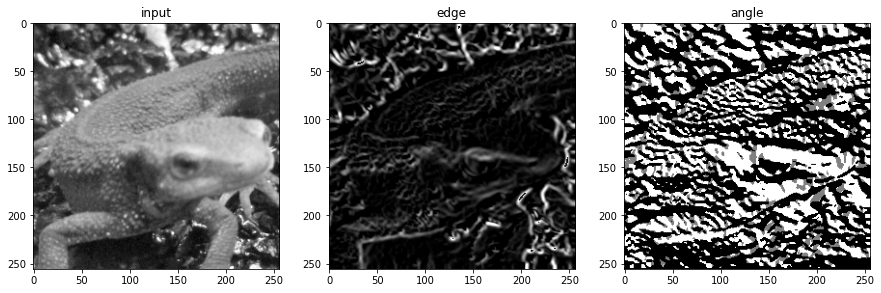

In [85]:
img = rgb2gray(img_orig.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4).astype(np.float32)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = np.sqrt(np.power(fx, 2)+np.power(fy, 2))
edge = edge.astype(np.uint8)

fx = np.maximum(fx, 1e-30)
angle = np.arctan(fy/fx)
angle = angle / np.pi *180
angle[angle<-22.5] = angle[angle<-22.5] + 180
_angle = np.zeros_like(angle, dtype=np.uint8)
_angle[np.where(angle<=22.5)] = 0
_angle[np.where((angle>22.5)&(angle<=67.5))] = 45
_angle[np.where((angle>67.5)&(angle<=112.5))] = 90
_angle[np.where((angle>112.5)&(angle<=157.5))] = 135
_angle = _angle.astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('edge'); plt.imshow(edge, cmap='gray')
plt.subplot(1, 3, 3); plt.title('angle'); plt.imshow(_angle, cmap='gray')
plt.show()

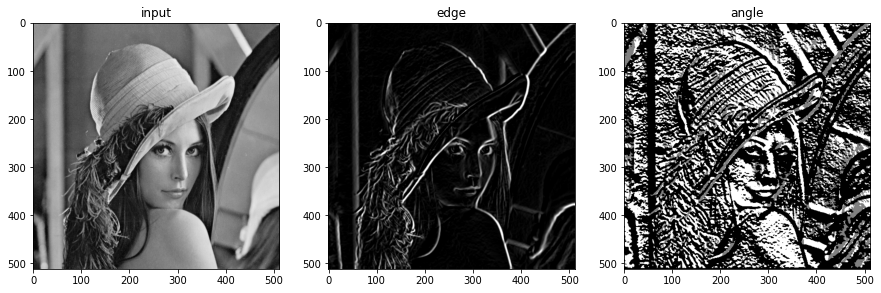

In [86]:
img = rgb2gray(img_lena.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = get_edge(fx, fy)
angle = get_angle(fx, fy)
angle = angle_quantization(angle)

img = img.astype(np.uint8)
edge = edge.astype(np.uint8)
angle = angle.astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('edge'); plt.imshow(edge, cmap='gray')
plt.subplot(1, 3, 3); plt.title('angle'); plt.imshow(angle, cmap='gray')
plt.show()

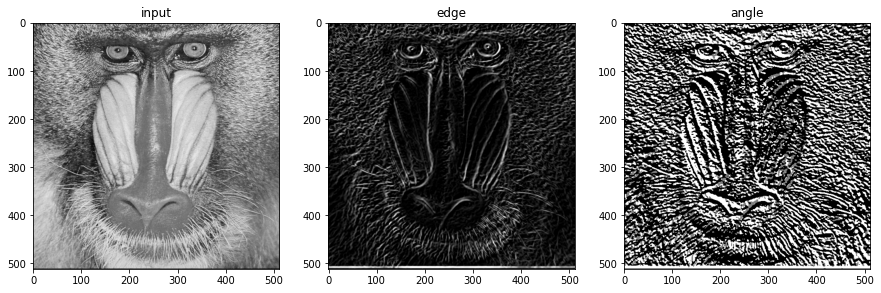

In [87]:
img = rgb2gray(img_mandrill.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = get_edge(fx, fy)
angle = get_angle(fx, fy)
angle = angle_quantization(angle)

img = img.astype(np.uint8)
edge = edge.astype(np.uint8)
angle = angle.astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('edge'); plt.imshow(edge, cmap='gray')
plt.subplot(1, 3, 3); plt.title('angle'); plt.imshow(angle, cmap='gray')
plt.show()

#42 Cannyエッジ検出 (Step.2) 細線化

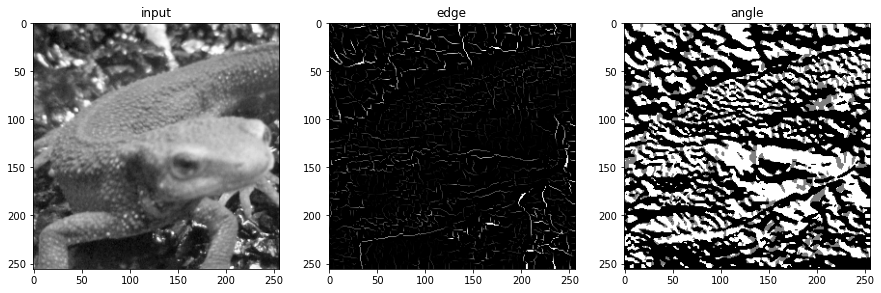

In [88]:
img = rgb2gray(img_orig.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = get_edge(fx, fy)
angle = get_angle(fx, fy)
angle = angle_quantization(angle)

edge = non_maxium_suppression(angle, edge)

img = img.astype(np.uint8)
edge = edge.astype(np.uint8)
angle = angle.astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('edge'); plt.imshow(edge, cmap='gray')
plt.subplot(1, 3, 3); plt.title('angle'); plt.imshow(angle, cmap='gray')
plt.show()

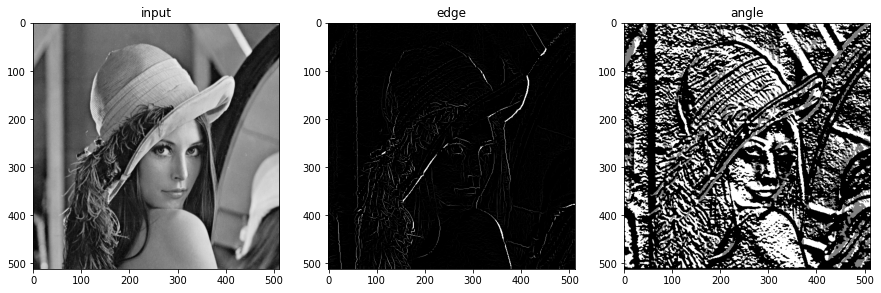

In [89]:
img = rgb2gray(img_lena.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4).astype(np.float32)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = get_edge(fx, fy)
angle = get_angle(fx, fy)
angle = angle_quantization(angle)

edge = non_maxium_suppression(angle, edge)

img = img.astype(np.uint8)
edge = edge.astype(np.uint8)
angle = angle.astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('edge'); plt.imshow(edge, cmap='gray')
plt.subplot(1, 3, 3); plt.title('angle'); plt.imshow(angle, cmap='gray')
plt.show()

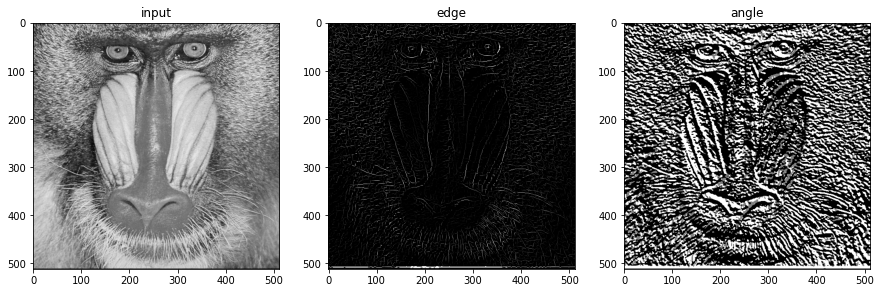

In [90]:
img = rgb2gray(img_mandrill.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4).astype(np.float32)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = get_edge(fx, fy)
angle = get_angle(fx, fy)
angle = angle_quantization(angle)

edge = non_maxium_suppression(angle, edge)

img = img.astype(np.uint8)
edge = edge.astype(np.uint8)
angle = angle.astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('edge'); plt.imshow(edge, cmap='gray')
plt.subplot(1, 3, 3); plt.title('angle'); plt.imshow(angle, cmap='gray')
plt.show()

#43 Cannyエッジ検出 (Step.3) ヒステリシス閾処理

(256, 256)


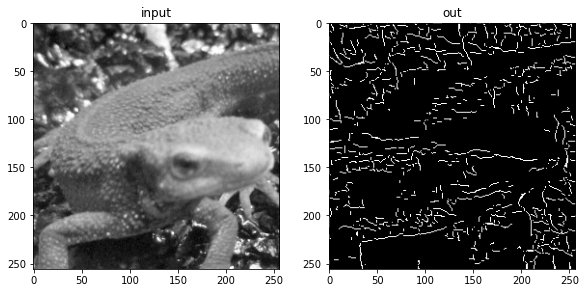

In [124]:
img = rgb2gray(img_orig.copy()).astype(np.float32)

gaussian = gaussian_filter_gray(img, 5, 1.4)

fx = sobel_filter(gaussian,3,mode='x',gray_image=True).astype(np.float32)
fy = sobel_filter(gaussian,3,mode='y',gray_image=True).astype(np.float32)

edge = get_edge(fx, fy)
angle = get_angle(fx, fy)
angle = angle_quantization(angle)

edge = non_maxium_suppression(angle, edge)

edge = hysterisis(edge, 50, 30)
print(edge.shape)

img = img.astype(np.uint8)
edge = edge.astype(np.uint8)
angle = angle.astype(np.uint8)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('out'); plt.imshow(edge, cmap='gray')
plt.show()

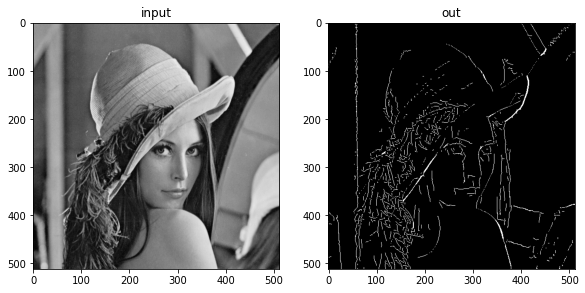

In [131]:
img = rgb2gray(img_lena.copy())

edge = Canny(img, 50, 10)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('out'); plt.imshow(edge, cmap='gray')
plt.show()

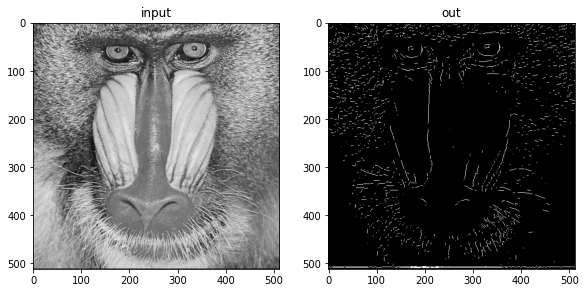

In [136]:
img = rgb2gray(img_mandrill.copy())

edge = Canny(img, 100, 150)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('input'); plt.imshow(img,cmap='gray')
plt.subplot(1, 3, 2); plt.title('out'); plt.imshow(edge, cmap='gray')
plt.show()